#### Imports & utilities

In [ ]:
# @title Install libraries
%%capture

!pip install m-phate scprep graphtools phate
!git clone https://github.com/theochem/procrustes.git
%cd procrustes
!pip install -r requirements.txt
!pip install .

In [ ]:
# @title Imports
import math, array, gc, gzip, os, struct, urllib.request, time
from os import path
import pickle, copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import scprep
import graphtools
import phate, m_phate
import m_phate.train
import m_phate.data
from phate import mds, vne

import jax
import cvxpy
import numpy as np
from procrustes import orthogonal, orthogonal_2sided
from scipy.spatial import procrustes

from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import linear_model

from jax import numpy as jnp
from jax import vmap, pmap, lax # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit, grad, random # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, ConvTranspose, Dense, Relu, Sigmoid, \
LeakyRelu, Flatten, LogSoftmax, FanOut, Softplus, elementwise, FanOut, BatchNorm, Dropout
from jax.nn.initializers import zeros
from jax.nn import leaky_relu, relu
from jax.tree_util import tree_map, tree_multimap, tree_reduce
from jax.experimental import optimizers

In [ ]:
# @title Utilities
_DATA = "./tmp"

def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return np.array(array.array("B", fh.read()), dtype=np.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / np.float32(255.)
  test_images = _partial_flatten(test_images) / np.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if permute_train:
    perm = np.random.RandomState(0).permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]

  return train_images, train_labels, test_images, test_labels

def binarize_batch(rng, i, images):
  i = i % num_batches
  batch = lax.dynamic_slice_in_dim(images, i * batch_size, batch_size)
  return random.bernoulli(rng, batch).astype(np.float32)

def overlay_plots(e1, e2, digit_ids=None, n_epochs=200):
  fig, ax1 = plt.subplots(
      1, 1, figsize=(15, 10), sharex='all', sharey='all')

  scprep.plot.scatter2d(e1,label_prefix="M-PHATE", ax=ax1)
  scprep.plot.scatter2d(e2,label_prefix="M-PHATE", ax=ax1)

def mds_plot(d, mp, ndim=-1):
  if ndim==-1:
    ndim=mp.n_components

  e = mds.embed_MDS(
      np.array(d),
      ndim=ndim,
      how=mp.mds,
      solver=mp.mds_solver,
      distance_metric=mp.mds_dist,
      n_jobs=mp.n_jobs,
      seed=mp.random_state,
      verbose=max(mp.verbose - 1, 0),
  )

  if digit_ids is None:
    if ndim == 3:
      scprep.plot.scatter3d(mp.graph.interpolate(e))
    else:
      scprep.plot.scatter2d(mp.graph.interpolate(e))
  else:
    if ndim == 3:
      scprep.plot.scatter3d(mp.graph.interpolate(e), c=np.tile(digit_ids, n_epochs))
    else:
      scprep.plot.scatter2d(mp.graph.interpolate(e), c=np.tile(digit_ids, n_epochs))


### VAE Notes


#### VAE
Want to learn a conditional model $p(x|z)$ that describes the dependence of observed data on latent variables, and a prior density 
$p(z)$ over the latent space. For data $x$, posterior is
$$
p(z|x) = \frac{p(x|z)p(z)}{p(x)}
$$
Computing $p(x)$ for high-dim data is hard.

----

#### Approximating $p(z|x)$
To avoid computing $p(x)$, approximate the posterior by $q_\lambda(z)$ that is close the true posterior in 'reverse' KL divergence: $KL(q_\lambda(z)||p(z|x))$ ([Eric Jang's post](https://blog.evjang.com/2016/08/variational-bayes.html) on why reverse KL):
$$
\lambda_* = \text{arg min}_{\lambda}\mathbb{E}_{q_\lambda(z)}\left[\log \frac{q_\lambda(z)}{p(z|x)}\right]
$$

<img src="https://lilianweng.github.io/lil-log/assets/images/VAE-graphical-model.png" alt="drawing" width="50%"/>

image from [Lilian Weng's blog post](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)

----

#### Finding $q_\lambda$
Don't have the true posterior $p (z|x)$, so can't directly optimize $KL(q_\lambda(z)||p(z|x))$.
$$
\begin{align}
KL(q_\lambda(z)||p(z|x)) &= \mathbb{E}_{q_\lambda(z)}[\log q_\lambda(z) - \log p(z|x)] \\
&= \mathbb{E}_{q_\lambda(z)}[\log q_\lambda(z) - (\log p(x,z) - \log p(x))] \\
&= \log p(x) + \mathbb{E}_{q_\lambda(z)}[\log q_\lambda(z) - \log p(x,z)] \\
&= \log p(x) + \mathbb{E}_{q_\lambda(z)}[\log q_\lambda(z) - \log p(x|z) - \log p(z)] \\
&= \log p(x) - \mathbb{E}_{q_\lambda(z)}\left[\log p(x|z) + \log \frac{p(z)}{q_\lambda(z)}\right] \\
&= \log p(x) - \left[\mathbb{E}_{q_\lambda(z)}[\log p(x|z)] + KL(q_\lambda(z)||p(z))\right] \\
&= \log p(x) - \mathcal{F}(x ; \lambda)
\end{align}
$$

$\mathcal{F}(x ; \lambda)$ is the *Evidence Lower BOund* (ELBO).
$$
\log p(x) = KL(q_\lambda(z)||p(z|x)) + \mathcal{F}(x ; \lambda)
$$
$p(x)$ is independent from $\lambda$. Minimizing the KL is equivalent to maximizing the ELBO $\mathcal{F}$.

----

#### $\beta$-VAE
$z$ is disentangled if each dimension of $z$ is sensitive to a single factor. $\beta$-VAE ([Higgins et al., 2017](https://openreview.net/forum?id=Sy2fzU9gl)) modifies the ELBO objective with a weight $\beta$ on the ELBO KL term to control the degree of disentanglement of $z$.
$$
\mathcal{F}_\beta(x ; \lambda) = \left[\mathbb{E}_{q_\lambda(z)}[\log p(x|z)] + \beta \cdot KL(q_\lambda(z)||p(z))\right]
$$
A higher $\beta$ encourages disentanglement and trades-off representational power. Choosing $\beta$ is not always obvious. 

For example, ([Fu et al., 2019](https://arxiv.org/abs/1903.10145)) propose a *Cyclical Annealing Schedule*. 
- A constant schedule produces heavily mixed latent codes for different sequences throughout the entire training process.
- A monotonic schedule starts with mixed codes, but soon divides the space into a mixture of 10 cluttered Gaussians in the annealing process (the division remains cluttered in the rest of training).
- A cyclical schedule initially behaves similarly to the monotonic schedule, but eventually learns better separated clusters & disentangled representations.

### Code

In [ ]:
""" 
VAE utilities
"""

def gaussian_kl(mu, sigmasq):
  """KL divergence from a diagonal Gaussian to the standard Gaussian."""
  return -0.5 * jnp.sum(1. + jnp.log(sigmasq) - mu**2. - sigmasq)

def gaussian_sample(rng, mu, sigmasq):
  """Sample a diagonal Gaussian."""
  return mu + jnp.sqrt(sigmasq) * random.normal(rng, mu.shape)

def bernoulli_logpdf(logits, x):
  """Bernoulli log pdf of data x given logits."""
  return -jnp.sum(jnp.logaddexp(0., jnp.where(x, -1., 1.) * logits))

def elbo(rng, params, images, beta1=1.0, beta2=1.0):
  """Monte Carlo estimate of the negative evidence lower bound."""
  enc_params, dec_params = params
  mu_z, sigmasq_z = encode(enc_params, images, rng=rng)
  logits_x = decode(dec_params, gaussian_sample(rng, mu_z, sigmasq_z))
  logits_x = logits_x.reshape(-1,28*28)
  return beta1*bernoulli_logpdf(logits_x, images.reshape(-1,28*28)) - beta2*gaussian_kl(mu_z, sigmasq_z)

def mse(rng, params, images, beta=1.0, beta2=1.0):
  """MSE"""
  def squared_error(x):
    enc_params, dec_params = params
    mu_z, _ = encode(enc_params, x, rng=rng)
    logits_x = decode(dec_params, mu_z)
    pred = logits_x.reshape(-1,28*28)
    return jnp.inner(x.reshape(-1,28*28)-pred, x.reshape(-1,28*28)-pred)/2.0
  return jnp.mean(jax.vmap(squared_error)(jnp.expand_dims(images,1)).flatten(), axis=0)

def _mse(rng, params, images, beta=1.0, beta2=1.0):
  """MSE"""
  def squared_error(x):
    enc_params, dec_params = params
    mu_z, _ = encode(enc_params, x, rng=rng)
    logits_x = decode(dec_params, mu_z)
    logits_x = random.bernoulli(rng, jnp.logaddexp(0., logits_x))
    pred = logits_x.reshape(-1,28*28)
    return jnp.inner(x.reshape(-1,28*28)-pred, x.reshape(-1,28*28)-pred)/2.0
  return jnp.mean(jax.vmap(squared_error)(jnp.expand_dims(images,1)).flatten(), axis=0)


In [ ]:
"""
Equations from Sec. 3.4 of Coifman & Hirn, Diffusion maps for changing data, 2013
"""

def _j(v_j, ps_a_i, ps_b_j):
  return v_j*jnp.inner(ps_a_i, ps_b_j)

def _it(v, ps_a_i, ps_b):
  return jnp.sum(vmap(_j, in_axes=(0, None, 1))(v, ps_a_i, ps_b))

@jit
def O(v, ps_a, ps_b):
  return vmap(_it, in_axes=(None, 1, None))(v, ps_a, ps_b)

def diffusion_kernel(diff_op, t=-1, t_max=100, gamma=-1):
  """compute diffusion kernel given diffusion op"""
  if t == -1:
    t = np.arange(t_max)
    t, h = t, vne.compute_von_neumann_entropy(diff_op, t_max=t_max)
    t_opt = vne.find_knee_point(y=h, x=t)
  else:
    t_opt = t
  diff_op_t = np.linalg.matrix_power(diff_op, t_opt)
  assert not np.isnan(np.sum(diff_op_t))

  if gamma == 1:
      # handling small values
      diff_op_t = diff_op_t + 1e-7
      _diff_potential = -1 * np.log(diff_op_t)
  elif gamma == -1:
      _diff_potential = diff_op_t
  else:
      c = (1 - gamma) / 2
      _diff_potential = ((diff_op_t) ** c) / c
  assert not np.isnan(np.sum(_diff_potential))

  return _diff_potential, t_opt


def cob_op(diff_op1, diff_op2):
  _,v1 = np.linalg.eig(diff_op1)
  _,v2 = np.linalg.eig(diff_op2)
  Ov = []
  for v in tqdm(diff_op2):
    Ov.append(O(v, v1.real, v2.real))
  return np.array(Ov)


def _cob_op(diff_op1, diff_op2):
  """map diff_op2 into diff_op1, return transformed diff_op2"""
  w1,v1 = np.linalg.eig(diff_op1)
  w2,v2 = np.linalg.eig(diff_op2)

  idx = w1.argsort()[::-1]   
  v1 = v1[:,idx]
  idx = w2.argsort()[::-1]   
  v2 = v2[:,idx]

  v1 = jnp.array(v1.real)
  v2 = jnp.array(v2.real)
  diff_op1 = jnp.array(diff_op1)
  diff_op2 = jnp.array(diff_op2)
  n = diff_op1.shape[0]
  Ov = jnp.zeros_like(diff_op2)
  def body_fun(i, val):
    return jax.ops.index_update(val, i, O(diff_op2[i], v1, v2))

  Ov = lax.fori_loop(0, n, 
                     body_fun, Ov)
  return Ov

def D_distance(diff_op1, diff_op2):
  """diffusion distance between two diffusion maps"""
  Odiff_op2 = _cob_op(diff_op1, diff_op2)
  return jnp.linalg.norm(diff_op1 - Odiff_op2)

In [ ]:
# @title Neural network functional

def pwl(*layers):
    """Combinator for composing layers in serial.
    Args:
      *layers: a sequence of layers, each an (init_fun, apply_fun) pair.
    Returns:
      A new layer, meaning an (init_fun, apply_fun) pair, representing the serial
      composition of the given sequence of layers.
    """
    nlayers = len(layers)
    init_funs, apply_funs = zip(*layers)
    def init_fun(rng, input_shape):
        params = []
        for init_fun in init_funs:
            rng, layer_rng = random.split(rng)
            input_shape, param = init_fun(layer_rng, input_shape)
            params.append(param)
        return input_shape, params
    def apply_fun(params, inputs, **kwargs):
        rng = kwargs.pop('rng', None)
        rngs = random.split(rng, nlayers) if rng is not None else (None,) * nlayers
        for fun, param, rng in zip(apply_funs, params, rngs):
            inputs = fun(param, inputs, rng=rng, **kwargs)
        return inputs
    def walk_fun(params, inputs, layers, **kwargs):
        rng = kwargs.pop('rng', None)
        rngs = random.split(rng, nlayers) if rng is not None else (None,) * nlayers
        profiles = []
        activations = []
        for i, (fun, param, rng) in enumerate(zip(apply_funs, params, rngs)):
            #if ((len(param) == 0) and (i != 0) and (i!=4) and i != len(apply_funs)):
            #    activations.append(inputs)
            inputs = fun(param, inputs, rng=rng, **kwargs)
            if i in layers:
              activations.append(inputs)
        return inputs, activations
    return init_fun, apply_fun, walk_fun

def add_noise_to_network(rng, params, var):
  """add noise to network weights"""
  # FIX THIS same rng, scaling
  return tree_map(lambda x: x+random.normal(rng, shape=x.shape)*jnp.sqrt(var),
                  params)

def trace_update(trace, enc_trace, dec_trace, test_elbo, test_kl, 
                 test_recons, test_mse, _test_elbo, _test_kl, _test_recons, _test_mse):
  """
  update a trace
  """
  trace['encoder_acts'].append(enc_trace)
  trace['decoder_acts'].append(dec_trace)
  trace['loss_elbo'].append(test_elbo)
  trace['loss_kl'].append(test_kl)
  trace['loss_recons'].append(test_recons)
  trace['loss_mse'].append(test_mse)
  trace['_loss_elbo'].append(_test_elbo)
  trace['_loss_kl'].append(_test_kl)
  trace['_loss_recons'].append(_test_recons)
  trace['_loss_mse'].append(_test_mse)
  return trace  

In [ ]:
# @title VAE architectures

"""
Encoder and decoder networks
"""
bottleneck_size=10

encoder_init, encode, encoder_walk = pwl(
    Dense(256), LeakyRelu,
    Dense(256), LeakyRelu,
    FanOut(2),
    stax.parallel(Dense(bottleneck_size), stax.serial(Dense(bottleneck_size), Softplus)),
)

decoder_init, decode, decoder_walk = pwl(
    Dense(256), LeakyRelu, 
    BatchNorm(axis=(0,1)),
    Dense(256), LeakyRelu,
    BatchNorm(axis=(0,1)),
    Dense(28 * 28)
)


def Reshape(newshape):
  """Layer construction function for a reshape layer."""
  init_fun = lambda rng, input_shape: (newshape,())
  apply_fun = lambda params, inputs, **kwargs: jnp.reshape(inputs,newshape)
  return init_fun, apply_fun
"""
encoder_init, encode, encoder_walk = pwl(
    Conv(16, (4,4), strides=(2,2),padding='SAME'), LeakyRelu,
    Conv(32, (4,4), strides=(2,2),padding='SAME'), LeakyRelu,
    Flatten,
    Dense(128), LeakyRelu,
    FanOut(2),
    stax.parallel(Dense(bottlenesampleck_size), stax.serial(Dense(bottleneck_size), Softplus)), # bottleneck
)
decoder_init, decode, decoder_walk = pwl(
    Dense(1568), LeakyRelu,
    Reshape((-1,7,7,32)),
    ConvTranspose(32, (4,4), strides=(2,2), padding='SAME'), LeakyRelu,
    ConvTranspose(16, (4,4), strides=(2,2), padding='SAME'), LeakyRelu,
    ConvTranspose(1, (4,4), strides=(1,1), padding='SAME')
)
"""
def image_reconstruct(rng, params, images, nrow, ncol, sample=True):
  """Sample images from the generative model."""
  enc_params, dec_params = params
  code = encode(enc_params, images)
  logits = decode(dec_params, code[0])
  if sample:
    sampled_images = random.bernoulli(rng, jnp.logaddexp(0., logits))
  else:
    sampled_images = logits
  return image_grid(nrow, ncol, sampled_images, (28, 28))

def image_sample(rng, params, nrow, ncol):
  """Sample images from the generative model."""
  _, dec_params = params
  code_rng, img_rng = random.split(rng)
  logits = decode(dec_params, random.normal(code_rng, (nrow * ncol, bottleneck_size)))
  sampled_images = random.bernoulli(img_rng, jnp.logaddexp(0., logits))
  return image_grid(nrow, ncol, sampled_images, (28, 28))

def image_grid(nrow, ncol, imagevecs, imshape):
  """Reshape a stack of image vectors into an image grid for plotting."""
  images = iter(imagevecs.reshape((-1,) + imshape))
  return jnp.vstack([jnp.hstack([next(images).T for _ in range(ncol)][::-1])
                    for _ in range(nrow)]).T

In [ ]:
# @title Download MNIST data & sample trace examples
train_images, train_labels, test_images, test_labels = mnist(permute_train=True)

np.random.seed(42)
# select the digit indices in the test set
trace_idx = []
for i in range(10):
    trace_idx.append(np.random.choice(np.argwhere(
        test_labels[:, i] == 1).flatten(), 10, replace=False))

trace_idx = np.concatenate(trace_idx)

# extract the selected images
x_trace = train_images[trace_idx]

#### Idea
Can M-Phate be used to identify good VAE training dynamics or find promising hyperparameters? e.g. 

- VAEs may suffer from posterior collapse ([Lucas et al., 2018](https://openreview.net/forum?id=r1xaVLUYuE)) if $\beta$ is not set appropriately
- Vanishing variance ([Takahashi et al., 2018](https://www.ijcai.org/Proceedings/2018/0374.pdf))
- Learn representations with good balance between reconstruction & disentanglement

#### Experiment
Evaluate a small convolutional VAE See if any difference in M-phate plots between networks that suffer from issues and those that are good.

In [ ]:
# @title $\beta$ schedules

"""
example schedules for \beta
"""

def linear_scheduler(i, ceil=20, max=1.):
  return jnp.maximum(i/ceil, max)

def annealed_scheduler(i, ceil=25, max=2.):
  pass

def cosine_scheduler(i, flr=0, ceil=100):
  return 0.0 + (1.0 - 0.0) * (1 + jnp.cos(np.pi * i/11 - np.pi)) / 2

In [ ]:
# @title evaluation and training utilities

@jit
def run_epoch(rng, epoch, opt_state, images, beta=1.0):
  def body_fun(i, opt_state):
    elbo_rng, data_rng = random.split(random.fold_in(rng, i))
    batch = binarize_batch(data_rng, i, images)
    loss = lambda params: -elbo(elbo_rng, params, batch, beta2=beta) / batch_size
    #loss = lambda params: mse(elbo_rng, params, batch)
    g = grad(loss)(get_params(opt_state))
    return opt_update(i, g, opt_state)
  return lax.fori_loop(0, num_batches, body_fun, opt_state)

@jit
def evaluate(opt_state, images):
  params = get_params(opt_state)
  elbo_rng, data_rng, image_rng = random.split(test_rng, 3)
  binarized_test = random.bernoulli(data_rng, images).astype(np.float32)
  test_elbo = elbo(elbo_rng, params, binarized_test) / images.shape[0]
  test_kl = elbo(elbo_rng, params, binarized_test, beta1=0.0) / images.shape[0]
  test_recons = elbo(elbo_rng, params, binarized_test, beta2=0.0) / images.shape[0]
  test_mse = _mse(elbo_rng, params, binarized_test)
  sampled_images = image_sample(image_rng, params, nrow, ncol)
  return (test_recons, test_kl, test_elbo, test_mse), sampled_images

@jit
def _evaluate(opt_state, images):
  """Per-example costs"""
  params = get_params(opt_state)
  elbo_rng, data_rng, image_rng = random.split(test_rng, 3)
  binarized_test = random.bernoulli(data_rng, images).astype(np.float32)
  binarized_test = jnp.expand_dims(binarized_test, 1)
  test_elbo = vmap(partial(elbo, elbo_rng, params))(binarized_test) 
  test_kl = vmap(elbo,in_axes=(None, None, 0, None, None))(elbo_rng, params, binarized_test, 0.0, 1.0)
  test_recons = vmap(elbo,in_axes=(None, None, 0, None, None))(elbo_rng, params, binarized_test, 1.0, 0.0)
  test_mse = vmap(_mse,in_axes=(None, None, 0))(elbo_rng, params, binarized_test)
  sampled_images = image_sample(image_rng, params, nrow, ncol)
  return (test_recons, test_kl, test_elbo, test_mse), sampled_images

def train(init_params, beta_scheduler=lambda x: 1.0):
  """trains a vae given a schedule for beta"""
  trace = {
    'encoder_acts': [],
    'decoder_acts': [],
    'loss_elbo': [],
    'loss_kl': [],
    'loss_recons': [],
    'loss_mse': [],
    '_loss_elbo': [],
    '_loss_kl': [],
    '_loss_recons': [],
    '_loss_mse': []
  }
  opt_state = opt_init(init_params)
  for epoch in tqdm(range(num_epochs)):
    tic = time.time()
    opt_state = run_epoch(random.PRNGKey(epoch), epoch, opt_state, train_images, beta_scheduler(epoch))
    test_cost, sampled_images = evaluate(opt_state, test_images)
    test_recons, test_kl, test_elbo, test_mse = test_cost

    _test_cost, _ = _evaluate(opt_state, x_trace)
    _test_recons, _test_kl, _test_elbo, _test_mse = _test_cost

    enc_params, dec_params = get_params(opt_state)

    ## sample=True if vae, otherwise false for standard ae.
    reconstructed_images = image_reconstruct(test_rng, (enc_params,dec_params), x_trace, nrow, ncol, sample=True)
    (mu_z, sigmasq_z), enc_trace = encoder_walk(enc_params, x_trace, enc_act_layers, rng=test_rng)
    dec_out, dec_trace = decoder_walk(dec_params, gaussian_sample(test_rng, mu_z, sigmasq_z), dec_act_layers)
    #dec_out, dec_trace = decoder_walk(dec_params, mu_z, dec_act_layers)

    if epoch % 10 == 0:
      tqdm.write("epoch: {} elbo: {:.3f} kl: {:.3f} recons: {:.3f} mse: {:.3f} ({:.2f} sec)".format(epoch, test_elbo, test_kl, test_recons, test_mse, time.time() - tic))
      plt.imsave(imfile.format(epoch), sampled_images, cmap=plt.cm.gray)

    # update trace
    trace = trace_update(trace, enc_trace, dec_trace, test_elbo, test_kl, test_recons, test_mse, _test_elbo, _test_kl, _test_recons, _test_mse)
  return trace, opt_state, sampled_images, reconstructed_images

In [ ]:
"""
main training cell
"""

# global params
step_size = 0.001
num_epochs = 200
batch_size = 32
nrow, ncol = 10, 10  # sampled image grid size

enc_act_layers = [0, 2, 4]
#dec_act_layers = [0, 2, 4]
# batch norm
dec_act_layers = [0, 3, 6]

#enc_act_layers = [0, 2, 5, 8]
#dec_act_layers = [0, 3, 5, 7]
#train_images = train_images.reshape(-1,28,28,1)
#test_images = test_images.reshape(-1,28,28,1)
#x_trace = x_trace.reshape(-1,28,28,1)

# batching variables
num_complete_batches, leftover = divmod(train_images.shape[0], batch_size)
num_batches = num_complete_batches + bool(leftover)

# put data onto gpu if available
train_images = jax.device_put(train_images)
test_images = jax.device_put(test_images)

imfile = os.path.join(os.getenv("TMPDIR", "/tmp/"), "mnist_vae_{:03d}.png")

opt_init, opt_update, get_params = optimizers.adam(1e-3)
#opt_init, opt_update, get_params = optimizers.adam(1e-5)

test_rng = random.PRNGKey(1)  # fixed prng key for evaluation


def experiment(var=0, seed=2, beta_schedule=0):
  """Train a single network with given parameters"""
  init_rng = random.PRNGKey(seed)
  enc_init_rng, dec_init_rng = random.split(init_rng) # prng key for encoder & decoder initialization

  # for fcnn
  _, init_encoder_params = encoder_init(enc_init_rng, (batch_size, 28 * 28))
  _, init_decoder_params = decoder_init(dec_init_rng, (batch_size, 10))
  init_decoder_params = add_noise_to_network(init_rng, init_decoder_params, var)

  # for cnn
  #_, init_encoder_params = encoder_init(enc_init_rng, (batch_size, 28, 28, 1))
  #_, init_decoder_params = decoder_init(dec_init_rng, (batch_size, bottleneck_size))

  # setup optimizer
  init_params = init_encoder_params, init_decoder_params

  if beta_schedule == 0:
    trace, opt_state, sampled_images, reconstructed_images = train(init_params)
  elif beta_schedule == 1:
    trace, opt_state, sampled_images, reconstructed_images = train(init_params, linear_scheduler)
  else:
    trace, opt_state, sampled_images, reconstructed_images = train(init_params, cosine_scheduler)
  enc_params, dec_params = get_params(opt_state)
  trace['opt_state'] = opt_state
  return trace, opt_state, sampled_images, reconstructed_images

In [ ]:
"""Train & generate traces for different networks trained differently"""

traces = []
opt_states = []
s_images = []
r_images = []
new_traces = []
covs = []
for v in np.linspace(0,1,20):
  #trace, opt_state, sampled_images, reconstructed_images = experiment(beta_schedule = s)
  trace, opt_state, sampled_images, reconstructed_images = experiment(var = v, seed = v)

  enc_params, dec_params = get_params(opt_state)

  traces.append(trace)
  opt_states.append(opt_state)
  s_images.append(sampled_images)
  r_images.append(reconstructed_images)


  """subsampling neurons at each layer """
  nt = []
  #idlen = [50, 200, 200, 300]
  idlen = [200, 200, 300]
  idxs = [np.random.choice(np.arange(a.reshape(a.shape[0], -1).shape[1]), 
                           size=idlen[i], replace=False) for i, a in enumerate(trace['decoder_acts'][0])]

  for epochtrace in trace['decoder_acts']:
    nt.append(np.concatenate([e.reshape(e.shape[0], -1)[:, idx] for idx, e in zip(idxs, epochtrace)], axis=1))
  new_traces.append(nt)

epoch: 0 elbo: -117.434 kl: -16.349 recons: -101.085 mse: 28.390 (11.13 sec)
epoch: 10 elbo: -103.903 kl: -18.973 recons: -84.930 mse: 22.363 (0.99 sec)
epoch: 20 elbo: -101.790 kl: -18.686 recons: -83.104 mse: 21.555 (0.99 sec)
epoch: 30 elbo: -100.878 kl: -18.967 recons: -81.912 mse: 21.079 (0.99 sec)
epoch: 40 elbo: -100.615 kl: -18.827 recons: -81.788 mse: 20.934 (0.99 sec)
epoch: 50 elbo: -100.573 kl: -19.118 recons: -81.455 mse: 20.604 (0.99 sec)
epoch: 60 elbo: -99.858 kl: -19.099 recons: -80.759 mse: 20.884 (0.99 sec)
epoch: 70 elbo: -99.301 kl: -19.207 recons: -80.094 mse: 20.440 (0.99 sec)
epoch: 80 elbo: -99.030 kl: -19.352 recons: -79.678 mse: 20.524 (1.00 sec)
epoch: 90 elbo: -98.599 kl: -19.213 recons: -79.386 mse: 20.536 (1.00 sec)
epoch: 100 elbo: -98.720 kl: -19.711 recons: -79.009 mse: 20.357 (0.99 sec)
epoch: 110 elbo: -98.495 kl: -19.374 recons: -79.121 mse: 20.412 (0.99 sec)
epoch: 120 elbo: -98.506 kl: -19.241 recons: -79.265 mse: 20.230 (0.99 sec)
epoch: 130 elbo

epoch: 0 elbo: -176.366 kl: -20.741 recons: -155.625 mse: 48.530 (0.98 sec)
epoch: 10 elbo: -123.710 kl: -17.837 recons: -105.873 mse: 30.606 (1.00 sec)
epoch: 20 elbo: -115.510 kl: -17.784 recons: -97.726 mse: 26.790 (0.99 sec)
epoch: 30 elbo: -111.985 kl: -18.906 recons: -93.079 mse: 25.631 (1.00 sec)
epoch: 40 elbo: -109.821 kl: -18.400 recons: -91.421 mse: 24.471 (0.99 sec)
epoch: 50 elbo: -108.277 kl: -18.727 recons: -89.550 mse: 24.074 (1.00 sec)
epoch: 60 elbo: -107.300 kl: -18.641 recons: -88.659 mse: 23.662 (0.99 sec)
epoch: 70 elbo: -106.423 kl: -18.895 recons: -87.528 mse: 23.194 (0.99 sec)
epoch: 80 elbo: -105.619 kl: -18.663 recons: -86.956 mse: 22.623 (0.99 sec)
epoch: 90 elbo: -104.955 kl: -18.876 recons: -86.079 mse: 22.334 (0.99 sec)
epoch: 100 elbo: -104.760 kl: -19.530 recons: -85.230 mse: 22.192 (1.00 sec)
epoch: 110 elbo: -104.001 kl: -19.089 recons: -84.911 mse: 22.066 (1.00 sec)
epoch: 120 elbo: -103.480 kl: -19.253 recons: -84.227 mse: 21.747 (0.98 sec)
epoch: 1

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#pickle.dump( traces, open( "traces_bn.p", "wb" ) )
#!mv traces_bn.p ../drive/MyDrive
#del(m_phate_ops)

In [ ]:
"""run m-phate on each trace"""

m_phate_ops = []
m_phate_datas = []
for i in tqdm(range(len(traces))):
  sampled_images = s_images[i]
  reconstructed_images = r_images[i]
  opt_state = opt_states[i]
  enc_params, dec_params = get_params(opt_state)
  trace = traces[i]
  nt = new_traces[i]

  decoder_trace_tensor = np.array(nt).transpose(0,-1,1)

  trace_data = decoder_trace_tensor
  trace_data = trace_data.transpose(0,-1,1)
  #idx1 = np.linspace(0, trace_data.shape[0], num=100, endpoint=False).astype(int)
  #idx2 = np.linspace(0, trace_data.shape[1], num=50, endpoint=False).astype(int)
  #trace_data = trace_data[idx1,:,:]
  #trace_data = trace_data[:,idx2,:]

  m_phate_op = m_phate.M_PHATE(intraslice_knn=2, interslice_knn=30, n_jobs=-2)
  m_phate_data = m_phate_op.fit_transform(trace_data) 

  m_phate_ops.append(m_phate_op)
  m_phate_datas.append(m_phate_data)
digit_ids = train_labels.argmax(1)[trace_idx]

n_epochs = trace_data.shape[0]
n_neurons = trace_data.shape[1]
n_samples = trace_data.shape[-1]

Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 1.48 seconds.
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.12 seconds.
      Calculating KMeans...
      Calculated KMeans in 79.26 seconds.
    Calculated landmark operator in 89.80 seconds.
  Calculated graph and diffusion operator in 90.11 seconds.
  Running PHATE on precomputed affinity matrix with 20000 observations.
  Calculating optimal t...
    Automatically selected t = 41
  Calculated optimal t in 35.56 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 20.53 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 120.51 seconds.
Calculated M-PHATE in 271.08 seconds.
Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 1.52 seconds.
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 6.73 seconds.
      Calculat

In [ ]:
#pickle.dump( m_phate_ops, open( "mphate_bn.p", "wb" ) )
#!mv mphate_bn.p ../drive/MyDrive

In [ ]:
def copy_graph(mp1, mp2):
  """copy mp2's graph to mp1"""
  mp = mp1
  mp._reset_embedding()
  mp._reset_potential()
  mp.graph._reset_landmarks()
  mp.graph._clusters = mp2.graph._clusters

  # transition matrices
  pmn = mp.graph._landmarks_to_data()

  # row normalize
  pnm = pmn.transpose()
  pmn = normalize(pmn, norm="l1", axis=1)
  pnm = normalize(pnm, norm="l1", axis=1)
  landmark_op = pmn.dot(pnm)  # sparsity agnostic matrix multiplication

  # store output
  mp.graph._landmark_op = landmark_op.toarray()
  mp.graph._transitions = pnm  

  return mp

In [ ]:
def map_mphate(mp1, mp2):
  """map mp1 to mp2 return kernels, diffusion distance"""

  # copy mphate2s graph to phate 1
  #mp1_aligned = copy_graph(copy.deepcopy(mp1), mp2)
  #mp2_diff_kernel, t = diffusion_kernel(mp2.diff_op)
  #mp1_diff_kernel,_ = diffusion_kernel(mp1_aligned.diff_op, t=t)

  mp2_aligned = copy_graph(copy.deepcopy(mp2), mp1)
  mp2_diff_kernel, t = diffusion_kernel(mp2_aligned.diff_op)
  mp1_diff_kernel,_ = diffusion_kernel(mp1.diff_op, t=t)

  diff_distance = D_distance(mp2_diff_kernel, mp1_diff_kernel)
  return (mp1_diff_kernel, mp2_diff_kernel), diff_distance

In [ ]:
distances = []
kernels_list = []
for i in tqdm(range(len(m_phate_ops))):
  if i == 0:
    distances.append(0)
    kernels_list.append(m_phate_datas[0]) 
    continue
  kernels, distance = map_mphate(m_phate_ops[i], m_phate_ops[0])
  distances.append(distance)
  kernels_list.append(kernels[0])

In [ ]:
mpo = pickle.load(open('../drive/MyDrive/mphate2.p','rb'))

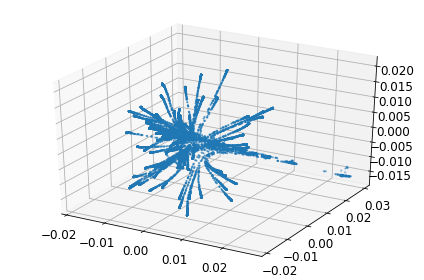

In [ ]:
digit_ids = None
mds_plot(k[0],mpo[0],ndim=3)

In [ ]:
mds_plot(kernels_list[1],m_phate_ops[0])

In [ ]:
testy = []
testx = []
c = []
cc = []

predictions = []
for i in range(len(k)):
  for j in range(i+1, len(k)):
    testy.append(np.linalg.norm(k[i]-k[j]))
    testx.append(np.abs(np.linspace(0,1,11)[i] - np.linspace(0,1,11)[j]))
    c.append(np.linspace(0,1,11)[i])
    cc.append(np.linspace(0,1,11)[j])
  

In [ ]:
testy = []
testx = []
c = []
cc = []
for i in range(len(kernels_list)):
  for j in range(i+1, len(kernels_list)):
    testy.append(np.linalg.norm(kernels_list[i]-kernels_list[j]))
    testx.append(np.abs([x for x in np.linspace(0,1,21) if x not in np.linspace(0,1,11)][i] - [x for x in np.linspace(0,1,21) if x not in np.linspace(0,1,11)][j]))
    c.append([x for x in np.linspace(0,1,21) if x not in np.linspace(0,1,11)][i])
    cc.append([x for x in np.linspace(0,1,21) if x not in np.linspace(0,1,11)][j])

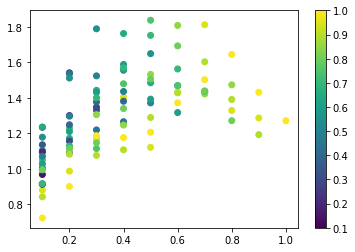

In [ ]:
plt.scatter(testx,testy, c=cc)
plt.colorbar()

In [ ]:
import scipy
scipy.stats.pearsonr(testx, testy)

(0.5653100104199265, 8.919570085367439e-10)

In [ ]:
pickle.dump( (distances,kernels_list), open( "mapped_mphate_data2.p", "wb" ) )

In [ ]:
!mv mapped_mphate_data2.p ../drive/MyDrive

In [ ]:
#res = orthogonal_2sided(diff_op_tt, diff_op_t1, single=False, translate=False, scale=False,lapack_driver='gesdd')
#_, diff_op_t, z = procrustes(diff_op_t1, diff_op_tt)
#res = orthogonal(diff_op_tt,diff_op_t1,lapack_driver='gesdd')

In [ ]:
"""need to fix this- for generating plots"""

i = 0
sampled_images = s_images[i]
reconstructed_images = r_images[i]
opt_state = opt_states[i]
enc_params, dec_params = get_params(opt_state)
trace = traces[i]
nt = new_traces[i]
m_phate_data = m_phate_datas[i]
m_phate_op = m_phate_ops[i]

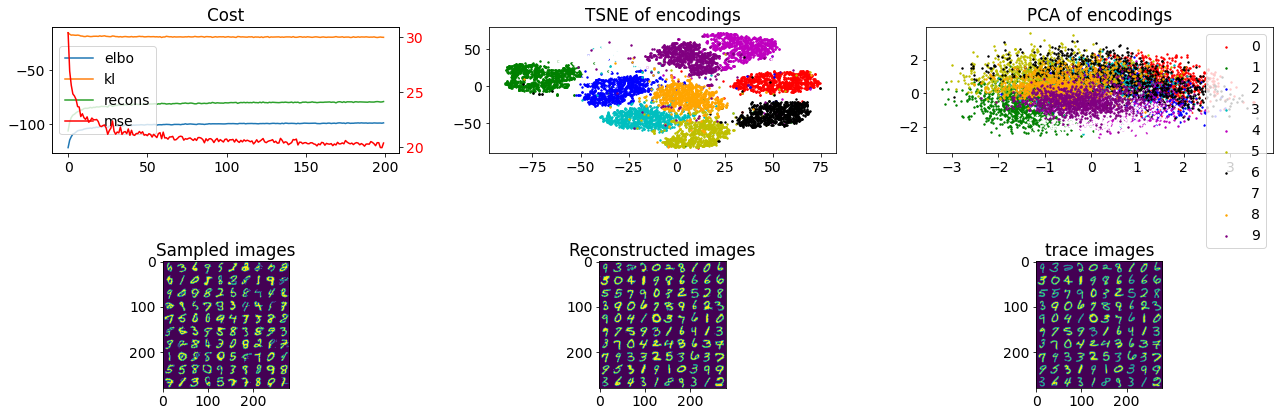

In [ ]:
"""
training plots
"""

plt.rc('font', size=14)
fig, ((ax1, ax2, ax3), (ax4, ax5,  ax6)) = plt.subplots(
    2, 3, figsize=(18, 6))

binarized_test = random.bernoulli(test_rng, test_images).astype(np.float32)
mu_z, sigmasq_z = encode(enc_params, binarized_test, rng=test_rng)
X_embedded_tsne = TSNE(n_components=2).fit_transform(mu_z)
X_embedded_pca = PCA(n_components=2).fit_transform(mu_z)

e = ax1.plot(trace['loss_elbo'],label='elbo')
k = ax1.plot(trace['loss_kl'],label='kl')
r = ax1.plot(trace['loss_recons'],label='recons')
ax1.set_title('Cost')

ax15 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
m = ax15.plot(trace['loss_mse'], color='red',label='mse')
ax15.tick_params(axis='y', labelcolor='red')

# double y axis labels
lns = e+k+r+m
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']
for g in np.unique(test_labels.argmax(1)):
    ix = np.where(test_labels.argmax(1) == g)
    ax2.scatter(X_embedded_tsne[ix,0], X_embedded_tsne[ix,1], c=colors[int(g)], label=g, s=2)
    ax3.scatter(X_embedded_pca[ix,0], X_embedded_pca[ix,1], c=colors[int(g)], label=g, s=2)
ax2.set_title('TSNE of encodings')
ax3.legend()
ax3.set_title('PCA of encodings')

ax4.imshow(sampled_images)
ax4.set_title('Sampled images')

ax5.imshow(reconstructed_images)
ax5.set_title('Reconstructed images')

ax6.imshow(image_grid(nrow, ncol, x_trace, (28, 28)))
ax6.set_title('trace images')

fig.suptitle('')
fig.tight_layout()

In [ ]:
# reshape cnn trace
"""
encoder_trace_tensor = np.array([np.concatenate([t.reshape(x_trace.shape[0],-1) for t in tr enc_act_layers],axis=1) for tr in trace['encoder_acts']]).transpose(0,-1,1)
idx = np.random.randint(encoder_trace_tensor.shape[1], size=256) # sample hidden units randomly
encoder_trace_tensor = encoder_trace_tensor[:,idx,:]
decoder_trace_tensor = np.array([np.concatenate([t.reshape(x_trace.shape[0],-1) for t in tr if tr in dec_act_layers],axis=1) for tr in trace['decoder_acts']]).transpose(0,-1,1)  
idx = np.random.randint(decoder_trace_tensor.shape[1], size=256) # sample hidden units randomly
decoder_trace_tensor = decoder_trace_tensor[:,idx,:]
"""

"""
fcnn
"""
decoder_trace_tensor = np.array(nt).transpose(0,-1,1)
encoder_trace_tensor = np.array(nt).transpose(0,-1,1)


# for fcnn
#encoder_trace_tensor = np.array([np.concatenate(tr,axis=1) for tr in trace['encoder_acts']]).transpose(0,-1,1)
#decoder_trace_tensor = np.array([np.concatenate(tr,axis=1) for tr in trace['decoder_acts']]).transpose(0,-1,1)

encoder_trace_tensor.shape, decoder_trace_tensor.shape

((200, 700, 100), (200, 700, 100))

#### M-phate

trace data should be `n_epochs x n_neurons x n_examples` tensor. The _flattened tensor_ will be returned by M-PHATE: `n_epochs*n_neurons x n_dim` matrix to be visualized.

In [ ]:
# @title trace setup

# for plots of hidden units in time
#trace_data = np.concatenate([encoder_trace_tensor, decoder_trace_tensor], axis=1)
trace_data = decoder_trace_tensor

n_epochs = trace_data.shape[0]
n_neurons = trace_data.shape[1]
n_samples = trace_data.shape[-1]

# for plots of samples in time
trace_data = trace_data.transpose(0,-1,1)
# the unique neuron id for each element of the flattened trace
neuron_ids = np.tile(np.arange(n_neurons), n_epochs)
# the current epoch for each element of the flattened trace
epoch = np.repeat(np.arange(n_epochs), n_neurons)
# the label of each digit we selected: this should be the same as `np.repeat(np.arange(10), 10)`
digit_ids = train_labels.argmax(1)[trace_idx]
# normalize the data
trace_data_norm = m_phate.utils.normalize(trace_data)

trace_data.shape

(200, 100, 700)

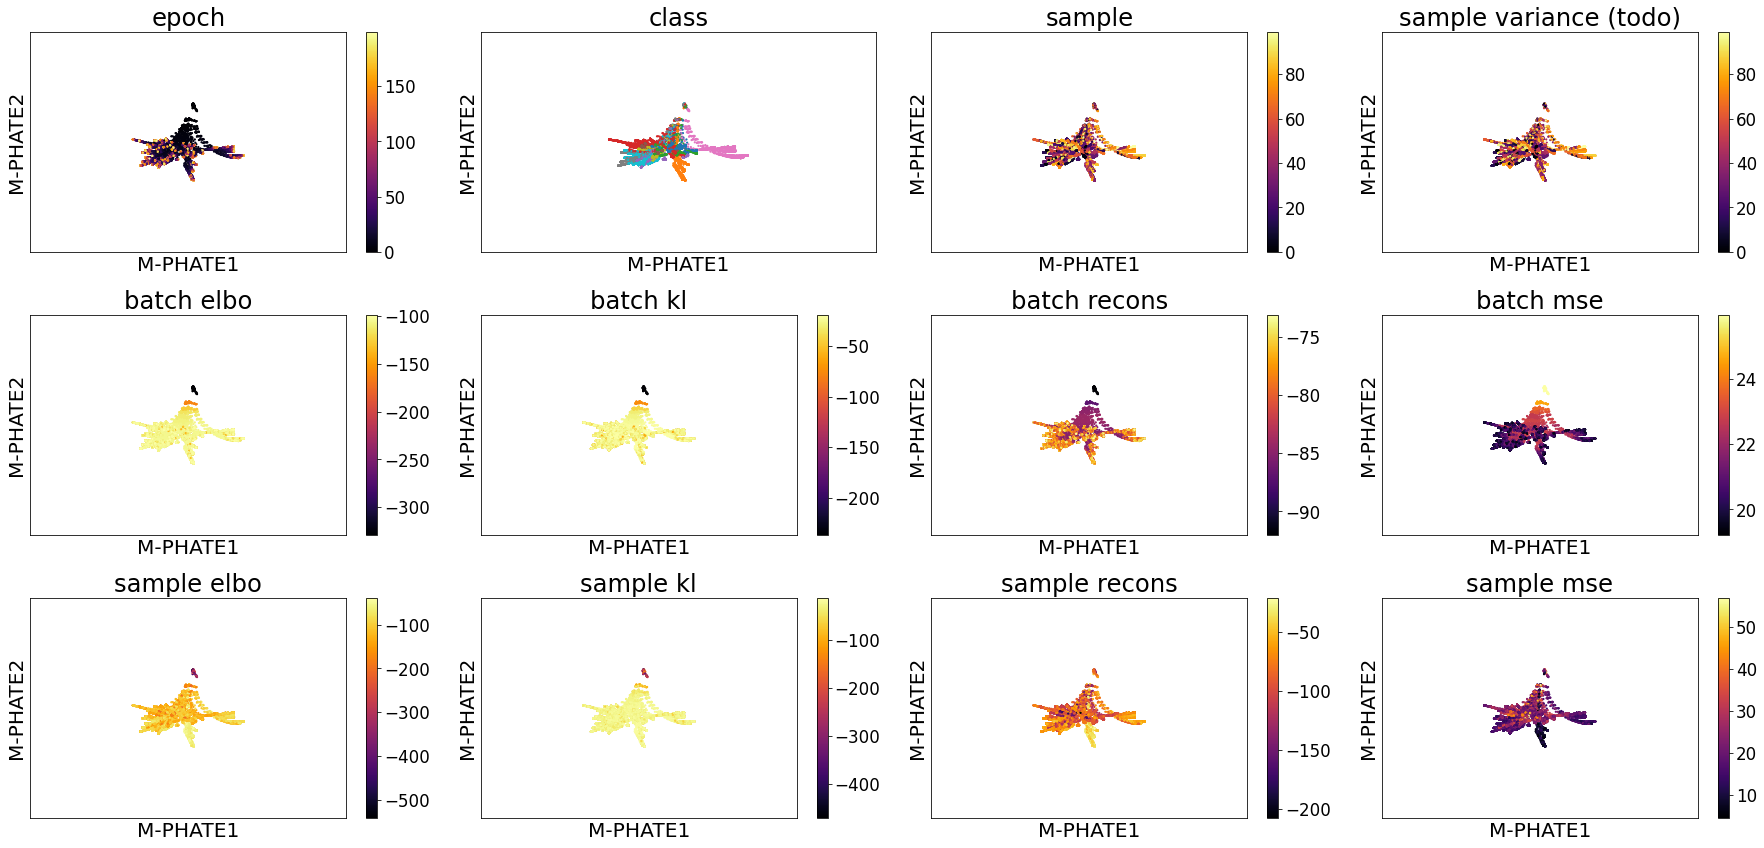

In [ ]:
# plot the results for samples
plt.rc('font', size=14)
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(
    3, 4, figsize=(25, 12), sharex='all', sharey='all')
scprep.plot.scatter2d(m_phate_data, c=np.repeat(np.arange(n_epochs), 100), ax=ax1, ticks=False,
                      title='epoch', label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=np.tile(digit_ids, n_epochs), ax=ax2, title='class',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=np.tile(np.arange(n_samples), n_epochs), ax=ax3, title='sample',
                      ticks=False, label_prefix="M-PHATE")

scprep.plot.scatter2d(m_phate_data, c=np.tile(np.arange(n_samples), n_epochs), ax=ax4, title='sample variance (todo)',
                      ticks=False, label_prefix="M-PHATE")

scprep.plot.scatter2d(m_phate_data, c=np.repeat(trace['loss_elbo'], 100), ax=ax5, ticks=False,
                      title='batch elbo', label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=np.repeat(trace['loss_kl'], 100), ax=ax6, ticks=False,
                      title='batch kl', label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=np.repeat(trace['loss_recons'], 100), ax=ax7, ticks=False,
                      title='batch recons', label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=np.repeat(trace['loss_mse'], 100), ax=ax8, ticks=False,
                      title='batch mse', label_prefix="M-PHATE")


# per-sample losses
scprep.plot.scatter2d(m_phate_data, c=np.concatenate(trace['_loss_elbo']), ax=ax9, ticks=False,
                      title='sample elbo', label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=np.concatenate(trace['_loss_kl']), ax=ax10, title='sample kl',
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=np.concatenate(trace['_loss_recons']), ax=ax11, title='sample recons',
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=np.concatenate(trace['_loss_mse']), ax=ax12, title='sample mse',
                      ticks=False, label_prefix="M-PHATE")
plt.tight_layout()

In [ ]:
#TODO fix
m_phate_data1=m_phate_data

In [ ]:
# TODO fix
t1,t2, z = procrustes(m_phate_data1, m_phate_data)
z

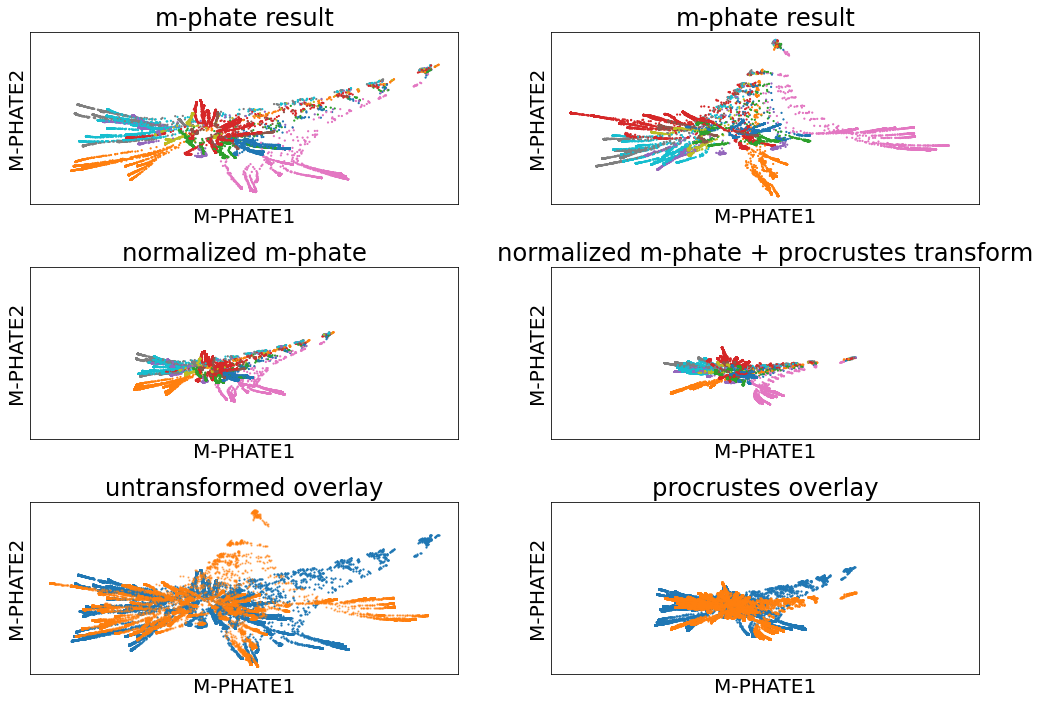

In [ ]:
# plot the results for samples
plt.rc('font', size=14)
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(
    3, 2, figsize=(15, 10), sharex='all', sharey='all')

scprep.plot.scatter2d(m_phate_data1, c=np.tile(digit_ids, n_epochs), ax=ax1, title='m-phate result',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=np.tile(digit_ids, n_epochs), ax=ax2, title='m-phate result',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(t1, c=np.tile(digit_ids, n_epochs), ax=ax3, title='normalized m-phate',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(t2, c=np.tile(digit_ids, n_epochs), ax=ax4, title='normalized m-phate + procrustes transform',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data1, ax=ax5, title='',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, alpha=0.5,ax=ax5, title='untransformed overlay',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(t1, ax=ax6, title='',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(t2,  ax=ax6, title='procrustes overlay',legend=False,
                      ticks=False, label_prefix="M-PHATE")

plt.tight_layout()

In [ ]:
"""make sure RAM > 15 gb to run 2-sided procrustes"""
#res = orthogonal_2sided(m_phate_data, m_phate_data1, single=False, translate=True, scale=True,lapack_driver='gesdd')
#res.new_a@res.t
res = orthogonal(m_phate_data, m_phate_data1, translate=True, scale=True,lapack_driver='gesdd')

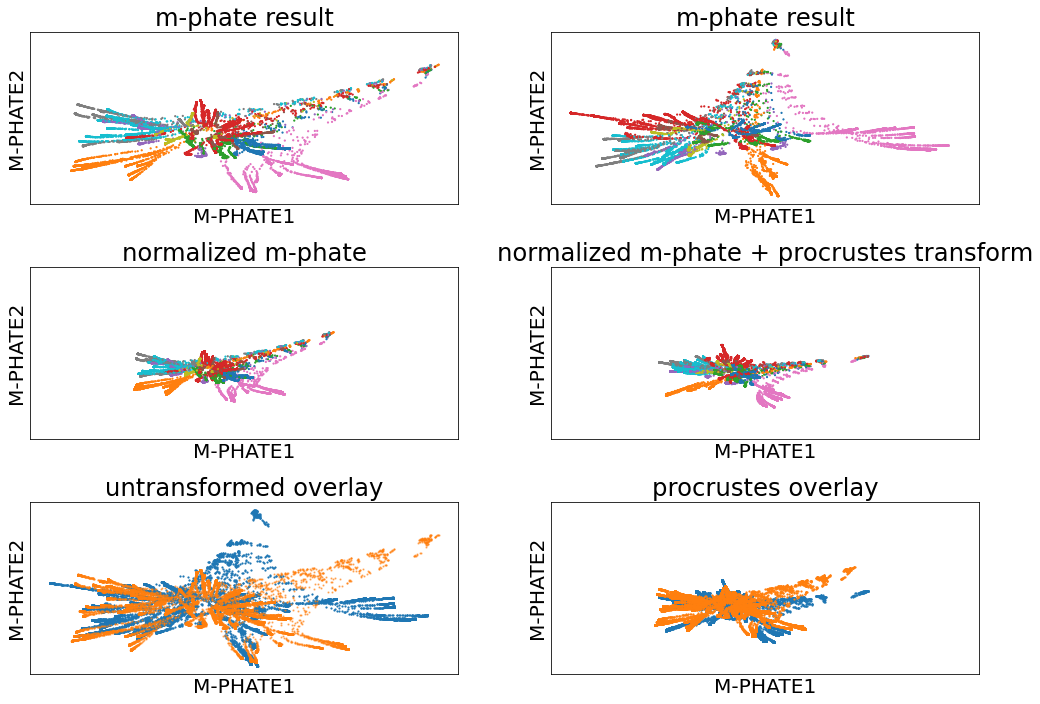

In [ ]:
# plot the results for samples
plt.rc('font', size=14)
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(
    3, 2, figsize=(15, 10), sharex='all', sharey='all')

scprep.plot.scatter2d(m_phate_data1, c=np.tile(digit_ids, n_epochs), ax=ax1, title='m-phate result',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=np.tile(digit_ids, n_epochs), ax=ax2, title='m-phate result',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(res.new_b, c=np.tile(digit_ids, n_epochs), ax=ax3, title='normalized m-phate',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(res.new_a@res.t, c=np.tile(digit_ids, n_epochs), ax=ax4, title='normalized m-phate + procrustes transform',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, ax=ax5, title='',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data1, alpha=0.5,ax=ax5, title='untransformed overlay',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(res.new_a@res.t, ax=ax6, title='',legend=False,
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(res.new_b,  ax=ax6, title='procrustes overlay',legend=False,
                      ticks=False, label_prefix="M-PHATE")

plt.tight_layout()

In [ ]:
# @title Save data

d = {
'data': m_phate_data,
'digit_ids':digit_ids,
'decoder_params':dec_params,
'encoder_params':enc_params,
'encoder_trace_tensor':encoder_trace_tensor,
'decoder_trace_tensor':decoder_trace_tensor,
'trace':trace
}
with open('data.pkl', 'wb') as f:
  pickle.dump(d,f)

##### Disentanglement experiment

##### beta-vae

Run inference on a number of images that are generated by fixing the value of one data generative factor while randomly sampling all others. If the independence and interpretability properties hold for the inferred representations, there will be less variance in the inferred latents that correspond to the fixed generative factor.

1. Choose a factor $y$ uniformly
2. Sample two sets of latent representations, $v_{1,l}$ and $v_{2,l}$, keeping the $k$-th factor fixed
3. Decode into $x_{1,l}$, $x_{2,l}$, and re-encode into $z_{1,l}$, $z_{2,l}$
4. Compute ansolute difference $z_{\textrm{diff}}^{l}$
5. Predict $y$ from $\bar{z}_\textrm{diff}$



##### FactorVae

In [ ]:
# @title beta vae metric

def compute_beta_vae_sklearn(params,
                             rng,
                             data,
                             batch_size=32,
                             num_train=100,
                             num_eval=50):
  test_images = data
  binarized_test = random.bernoulli(rng, test_images).astype(np.float32)
  train_points, train_labels = _generate_training_batch(params, data, rng, batch_size=batch_size, num_points=num_eval)

  #logging.info("Training sklearn model.")
  model = linear_model.LogisticRegression()
  model.fit(train_points, train_labels)
  train_accuracy = model.score(train_points, train_labels)
  train_accuracy = np.mean(model.predict(train_points) == train_labels)

  #logging.info("Generating evaluation set.")
  eval_points, eval_labels = _generate_training_batch(
      params, data, rng, batch_size=batch_size, num_points=num_eval)
  eval_accuracy = model.score(eval_points, eval_labels)

  scores_dict = {}
  scores_dict["train_accuracy"] = train_accuracy
  scores_dict["eval_accuracy"] = eval_accuracy
  return scores_dict


def _generate_training_batch(params, data, rng,
                             batch_size=5, num_points=2000):
  points = None  # Dimensionality depends on the representation function.
  labels = np.zeros(num_points, dtype=np.int64)
  for i in range(num_points):
    labels[i], feature_vector = _generate_training_sample(params, data, rng,
                                                          batch_size=batch_size)
    if points is None:
      points = np.zeros((num_points, feature_vector.shape[0]))
    points[i, :] = feature_vector
  return points, labels

def _generate_training_sample(params, data, rng,
                              batch_size=5):
  enc_params, dec_params = params
  code_rng, img_rng = random.split(rng)

  # Select random coordinate to keep fixed.
  index =  np.random.randint(10)

  factors = random.normal(test_rng, (2*batch_size, 10))
  factors1 = factors[batch_size:]
  factors2 = factors[:batch_size]
  # Ensure sampled coordinate is the same across pairs of samples.
  factors1 = factors1.at[:, index].set(factors2[:, index])
  # Transform latent variables to observation space.
  logits1 = decode(dec_params, factors1)
  observation1 = random.bernoulli(img_rng, jnp.logaddexp(0., logits1)).astype(np.float32)
  logits2 = decode(dec_params, factors2)
  logits2 = random.bernoulli(img_rng, jnp.logaddexp(0., logits2))
  observation2 = random.bernoulli(img_rng, jnp.logaddexp(0., logits2)).astype(np.float32)

  # Compute representations based on the observations.
  representation1 = encode(enc_params,observation1)
  representation2 = encode(enc_params,observation2)
  # Compute the feature vector based on differences in representation.
  feature_vector = np.mean(np.abs(representation1[0] - representation2[0]), axis=0)
  return index, feature_vector

In [ ]:
res = compute_beta_vae_sklearn((enc_params, dec_params),
                             test_rng,
                             test_images,
                             batch_size=5,
                             num_train=2000,
                             num_eval=2000)
res

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


$\beta$  | $\beta$  score | Factor score 
-------------------|------------------|------------------
$\beta=1$       | 1.0     |
$\beta=10$       | 0.891     | 